<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/pytorch/blob/main/fraud-detection-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

An autoencoder is a neural networks that learns the "hidden"(latent) representation of the input. The number of features of the latent representation is typically much smaller than the number of features in the input.
An autoencoder has two parts: an encoder, and a decoder, which is typically the "inverse" of the encoder. The way an autoencoder works is by learning to reproduce the input. In the figure below, the result of learning would be to make the output as close as possible to the input

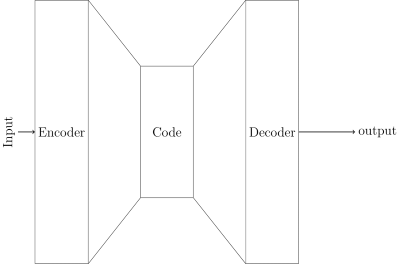

## Autoencoders for anomaly detection

An anomaly is an object different from the "norm". The idea is that after training an autoencoder can reproduce "normal" input with small error. An input that produces a "large" error is classified as an anomaly.
In this notebook we will use the above idea to detect credit card fraud

In [1]:
import torch
import torchvision as vision
import pandas as pd
import numpy as np

## The data

The data contains 31 features. Most of them are the principal components from a PCA preprocessing so we don't have a direct interpretation for those. The remaining 3 are time, when the transaction occurred relative to the first one, the amount and the label to denote if the transaction was legitimate or a fraud.
A detailed description of the dataset can be found [here](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

A direct quotation from that page

"The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection."

In [2]:
from google.colab import files
file=files.upload()
!mkdir -p /root/.kaggle
!mv kaggle.json  /root/.kaggle
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip>/dev/null

Saving kaggle.json to kaggle.json
creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y


## Data preprocessing
The time feature is not used and will be dropped. The "Class" column is changed to "label" since "Class" is a keyword. Finally, the data is rescaled as we did before to help in the convergence.

In [3]:
df=pd.read_csv("creditcard.csv")
df.rename(columns={'Class':'label'},inplace=True)
df=df.drop('Time',axis=1)
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,label
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## Training
Our aim is for the autoencoder to learn "legitimate" transactions. For that end, the training is done on the non-fraud data, i.e. label=0

In [4]:
fraud=df[df.label==1]
clean=df[df.label==0]
print("# of fraud samples {}. # of clean samples {} ".format(
            len(fraud),len(clean)))

# of fraud samples 492. # of clean samples 284315 


We need to retain a fraction of the "clean" data for testing later on

In [5]:
TRAINING_SAMPLE=200000
clean=clean.sample(frac=1).reset_index(drop=True)
train_input=clean.iloc[:TRAINING_SAMPLE].drop('label',axis=1)
test_input=clean.iloc[TRAINING_SAMPLE:].append(fraud)

In [6]:
test_input.label.value_counts()

0    84315
1      492
Name: label, dtype: int64

In [7]:
from sklearn.preprocessing import MinMaxScaler

pipeline=MinMaxScaler()
pipeline.fit(train_input)
X_test, y_test = test_input.drop('label', axis=1), test_input.label
X_train_transformed = pipeline.transform(train_input)
X_test_transformed = pipeline.transform(X_test)


Create a custom dataset

In [8]:
from torch.utils.data import Dataset,DataLoader
class CustomDataset(Dataset):
    def __init__(self,data):
        #self.data=frame.to_numpy(dtype=np.float32)        
        self.data=data
    def __getitem__(self,idx):
            return torch.as_tensor(self.data[idx],dtype=torch.float32)
    
    def __len__(self):
        return len(self.data)

In [9]:
train_dataset=CustomDataset(X_train_transformed)
train_loader=DataLoader(train_dataset,batch_size=256)

No attempt was made to optimize the network architecture

In [10]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.fc2=nn.Linear(in_features=29,out_features=16)
        self.fc3=nn.Linear(in_features=16,out_features=8)
        self.fc4=nn.Linear(in_features=8,out_features=4)
        self.fc5=nn.Linear(in_features=4,out_features=2)
        # Decoder
        self.fc6=nn.Linear(in_features=2,out_features=4)
        self.fc7=nn.Linear(in_features=4,out_features=8)
        self.fc8=nn.Linear(in_features=8,out_features=16)
        self.fc9=nn.Linear(in_features=16,out_features=29)
        ## Since some of the PCA components are negative
        self.relu=nn.ELU()
    def forward(self,x):
        x=self.fc2(x)
        x=self.relu(x)
        x=self.fc3(x)
        x=self.relu(x)
        x=self.fc4(x)
        x=self.relu(x)
        x=self.fc5(x)
        x=self.relu(x)
        x=self.fc6(x)
        x=self.relu(x)
        x=self.fc7(x)
        x=self.relu(x)
        x=self.fc8(x)
        x=self.relu(x)
        x=self.fc9(x)
     
        return x
        

In [ ]:

    output=model(input)
    loss=loss_fn(output.squeeze(),price)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loop.set_postfix(loss=loss.item())

In [21]:
from torch.nn import MSELoss
from torch.optim import Adam
from tqdm import tqdm
model=Net()
optimizer=Adam(model.parameters())
loss_fn=MSELoss()
epochs=50
for epoch in range(epochs):
    loop=tqdm(train_loader)
    loop.set_description("Epoch [{}/{}]".format((epoch+1),epochs))
    for x in loop:
        optimizer.zero_grad()
        y=model(x)
        loss=loss_fn(x,y)
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())
   

Epoch [50/50]: 100%|██████████| 782/782 [00:05<00:00, 135.30it/s, loss=0.00127]


## Detecting fraud

The mse of test data is computed. Because the autoencoder learned the "legitimate" transactions we consider each transaction having mse > some threshold to be fraud.

This is an extremely crude analysis and is done as a learning example

In [22]:
test_predict = model(torch.as_tensor(X_test_transformed,dtype=torch.float32))

In [23]:
mse = np.mean(np.power(X_test_transformed - test_predict.detach().numpy(), 2), axis=1)

num clean 84315. num fraud 492


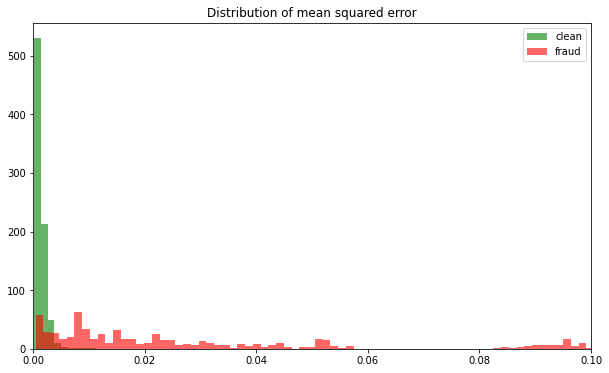

In [24]:
import matplotlib.pyplot as plt
clean = mse[y_test==0]
fraud = mse[y_test==1]
print("num clean {}. num fraud {}".format(len(clean),len(fraud)))
fig, ax = plt.subplots(figsize=(10,6))


ax.hist(clean, bins=100, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=100, density=True, label="fraud", alpha=.6, color="red")
plt.xlim((0,0.1))
plt.title("Distribution of mean squared error")
plt.legend()
plt.show()

In [25]:

outliers=mse>np.mean(clean)+2*np.std(clean)

print("num of samples classified as fraud {}".format(outliers.sum()))


num of samples classified as fraud 1655


In [26]:
from sklearn.metrics import confusion_matrix

cm= confusion_matrix(outliers,y_test)
# true/false positives/negatives
(tn, fn, 
 fp, tp) = cm.flatten()

In [27]:
print("Confusion matrix \n{}".format(cm))

print("precision: tp/(fp+tp)= {:.2%}".format(tp/(fp+tp)))
print("recall: tp/(fn+tp)={:.2%}".format(tp/(fn+tp)))

Confusion matrix 
[[83074    78]
 [ 1241   414]]
precision: tp/(fp+tp)= 25.02%
recall: tp/(fn+tp)=84.15%
